# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

/home/hiroki/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

In [9]:
dev_paths['fan']['train'][-1]

'/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/add_dev_data/fan/train/section_05_target_train_normal_0002_strength_1_temp_max.wav'

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'])
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict['model'], strict=False)
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# run

In [14]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-04-26 20:51:05,941 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-04-26 20:51:05,942 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:51:05,943 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:02<01:50,  2.36s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:03<01:24,  1.84s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:05<01:14,  1.65s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:06<01:09,  1.57s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:08<01:05,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:09<01:02,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:11<01:00,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:12<00:58,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:13<00:57,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:15<00:55,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:16<00:54,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:18<00:52,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:19<00:50,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:21<00:49,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:22<00:47,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:24<00:46,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:25<00:44,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:26<00:43,  1.44s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:28<00:42,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:29<00:40,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:31<00:39,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:32<00:37,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:34<00:36,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:35<00:35,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:37<00:33,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:38<00:32,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:40<00:30,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:41<00:29,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:43<00:28,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:44<00:27,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:46<00:25,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:47<00:23,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:49<00:23,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:50<00:21,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:52<00:19,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:53<00:17,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:55<00:16,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:56<00:14,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:58<00:13,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [00:59<00:11,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:01<00:10,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:02<00:08,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:04<00:07,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:05<00:05,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:06<00:04,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:08<00:02,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:04<00:16,  4.17s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:07<00:04,  2.08s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.82s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:07<00:04,  2.06s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.81s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]
2021-04-26 20:52:42,866 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/fan_features.pkl
2021-04-26 20:52:42,871 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-04-26 20:52:42,872 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:52:42,872 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 96.925813198 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:03<02:53,  3.70s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:05<01:51,  2.42s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:06<01:30,  2.02s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:08<01:18,  1.78s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:09<01:12,  1.68s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:11<01:06,  1.59s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:12<01:03,  1.55s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:14<01:00,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:15<00:57,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:16<00:56,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:18<00:54,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:19<00:52,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:21<00:50,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:22<00:49,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:24<00:48,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:25<00:46,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:27<00:45,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:28<00:43,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:29<00:42,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:31<00:40,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:32<00:38,  1.44s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:34<00:37,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:35<00:36,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:37<00:35,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:38<00:33,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:40<00:31,  1.44s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:41<00:30,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:42<00:28,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:44<00:27,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:45<00:26,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:47<00:24,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:48<00:23,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:50<00:21,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:51<00:20,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:53<00:18,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:54<00:17,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:56<00:15,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:57<00:14,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:59<00:13,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [01:00<00:11,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:01<00:10,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:03<00:08,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:04<00:07,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:06<00:05,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:07<00:04,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:09<00:02,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 98%|█████████▊| 47/48 [01:10<00:01,  1.45s/it]

torch.Size([124, 160000])
torch.Size([124, 320000])


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 1/6 [00:03<00:18,  3.75s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 2/6 [00:05<00:09,  2.38s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 3/6 [00:06<00:05,  1.95s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 4/6 [00:08<00:03,  1.77s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 5/6 [00:09<00:01,  1.64s/it]

torch.Size([122, 160000])
torch.Size([122, 320000])


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 1/6 [00:03<00:18,  3.73s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 2/6 [00:05<00:09,  2.37s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 3/6 [00:06<00:05,  1.97s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 4/6 [00:08<00:03,  1.76s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 5/6 [00:09<00:01,  1.64s/it]

torch.Size([5, 160000])
torch.Size([5, 320000])


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]
2021-04-26 20:54:17,753 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/gearbox_features.pkl
2021-04-26 20:54:17,755 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-04-26 20:54:17,756 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:54:17,757 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 94.883026361 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:03<03:01,  3.86s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:05<01:52,  2.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:06<01:29,  1.99s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:08<01:17,  1.76s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:09<01:11,  1.67s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:11<01:06,  1.58s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:12<01:03,  1.55s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:14<01:00,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:15<00:57,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:16<00:56,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:18<00:54,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:19<00:53,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:21<00:51,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:22<00:49,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:24<00:48,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:25<00:46,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:27<00:45,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:28<00:43,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:30<00:42,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:31<00:40,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:32<00:39,  1.44s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:34<00:38,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:35<00:36,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:37<00:35,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:38<00:33,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:40<00:32,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:41<00:30,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:43<00:28,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:44<00:27,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:46<00:26,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:47<00:24,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:48<00:23,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:50<00:21,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:51<00:20,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:53<00:18,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:54<00:17,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:56<00:16,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:57<00:14,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:59<00:13,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [01:00<00:11,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:02<00:10,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:03<00:08,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:05<00:07,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:06<00:05,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:07<00:04,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:09<00:02,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:10<00:00,  1.48s/it]


torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.41s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:03,  1.96s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.77s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.38s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:03,  1.95s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.78s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
2021-04-26 20:55:53,685 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/pump_features.pkl
2021-04-26 20:55:53,690 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-04-26 20:55:53,691 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:55:53,692 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 95.930140257 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:01<01:21,  1.74s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:03<01:11,  1.55s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:04<01:08,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:06<01:05,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:07<01:03,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:08<01:01,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:10<00:59,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:11<00:58,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:13<00:56,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:14<00:55,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:16<00:53,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:17<00:52,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:19<00:50,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:20<00:50,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:22<00:50,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:23<00:48,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:25<00:47,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:26<00:45,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:28<00:44,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:29<00:42,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:31<00:40,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:32<00:38,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:34<00:37,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:35<00:35,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:37<00:33,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:38<00:32,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:40<00:30,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:41<00:29,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:43<00:27,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:44<00:26,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:46<00:24,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:47<00:23,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:48<00:21,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:50<00:20,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:51<00:18,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:53<00:17,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:54<00:15,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:56<00:14,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:57<00:13,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [00:59<00:11,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:00<00:10,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:02<00:08,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:03<00:07,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:04<00:05,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:06<00:04,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:07<00:02,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:09<00:00,  1.08s/it]

torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:04,  2.01s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.81s/it]

torch.Size([100, 160000])
torch.Size([100, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:07<00:04,  2.06s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.81s/it]

torch.Size([90, 160000])
torch.Size([90, 320000])


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]
2021-04-26 20:57:28,723 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/slider_features.pkl
2021-04-26 20:57:28,726 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-04-26 20:57:28,726 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:57:28,727 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 95.033149719 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:03<02:55,  3.73s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:05<01:48,  2.37s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:06<01:27,  1.94s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:08<01:17,  1.76s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:09<01:10,  1.64s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:10<01:06,  1.59s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:12<01:02,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:13<01:00,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:15<00:58,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:16<00:55,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:18<00:54,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:19<00:52,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:21<00:51,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:22<00:49,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:23<00:47,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:25<00:46,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:26<00:44,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:28<00:43,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:29<00:42,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:31<00:40,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:32<00:39,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:34<00:38,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:35<00:37,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:37<00:36,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:38<00:34,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:40<00:32,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:41<00:31,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:43<00:29,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:44<00:28,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:46<00:27,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:47<00:26,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:49<00:24,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:50<00:22,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:52<00:20,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:53<00:19,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:55<00:17,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:56<00:16,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:58<00:14,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:59<00:13,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [01:00<00:11,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:02<00:10,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:03<00:08,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:05<00:07,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:07<00:06,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:08<00:04,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:10<00:03,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:04,  2.03s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.82s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:15,  3.95s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:04,  2.03s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:08<00:01,  1.83s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
2021-04-26 20:59:05,901 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/ToyCar_features.pkl
2021-04-26 20:59:05,903 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-04-26 20:59:05,904 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 20:59:05,904 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 97.175396919 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:03<02:34,  3.28s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:04<01:43,  2.25s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:06<01:25,  1.90s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:07<01:17,  1.77s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:09<01:12,  1.68s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:10<01:06,  1.60s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:12<01:03,  1.56s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:13<01:00,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:15<00:58,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:16<00:56,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:18<00:54,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:19<00:55,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:21<00:54,  1.56s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:22<00:52,  1.55s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:24<00:50,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:25<00:49,  1.54s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:27<00:46,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:28<00:45,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:30<00:43,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:31<00:41,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:33<00:40,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:34<00:39,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:36<00:37,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:37<00:36,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:39<00:35,  1.53s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:41<00:33,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:42<00:31,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:44<00:30,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:45<00:28,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:47<00:27,  1.51s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:48<00:25,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:50<00:24,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:51<00:22,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:53<00:20,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:54<00:19,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:55<00:17,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:57<00:16,  1.49s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:58<00:14,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [01:00<00:13,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [01:01<00:11,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:03<00:10,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:04<00:08,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:06<00:07,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:07<00:05,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:09<00:04,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:10<00:02,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:12,  3.17s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:03,  1.90s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:07<00:01,  1.74s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:03,  1.84s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:07<00:01,  1.70s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
2021-04-26 21:00:41,969 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/ToyTrain_features.pkl
2021-04-26 21:00:41,983 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-04-26 21:00:41,984 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 21:00:41,985 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 96.076234102 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0
torch.Size([128, 160000])
torch.Size([128, 320000])


  2%|▏         | 1/48 [00:03<02:27,  3.14s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  4%|▍         | 2/48 [00:04<01:37,  2.13s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  6%|▋         | 3/48 [00:06<01:21,  1.82s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


  8%|▊         | 4/48 [00:07<01:13,  1.67s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 10%|█         | 5/48 [00:08<01:08,  1.58s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 12%|█▎        | 6/48 [00:10<01:05,  1.56s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 15%|█▍        | 7/48 [00:11<01:02,  1.52s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 17%|█▋        | 8/48 [00:13<01:00,  1.50s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 19%|█▉        | 9/48 [00:14<00:57,  1.48s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 21%|██        | 10/48 [00:16<00:55,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 23%|██▎       | 11/48 [00:17<00:54,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 25%|██▌       | 12/48 [00:19<00:52,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 27%|██▋       | 13/48 [00:20<00:51,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 29%|██▉       | 14/48 [00:21<00:49,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 31%|███▏      | 15/48 [00:23<00:47,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 33%|███▎      | 16/48 [00:24<00:46,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 35%|███▌      | 17/48 [00:26<00:44,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 38%|███▊      | 18/48 [00:27<00:43,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|███▉      | 19/48 [00:29<00:42,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 42%|████▏     | 20/48 [00:30<00:40,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 44%|████▍     | 21/48 [00:32<00:39,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 46%|████▌     | 22/48 [00:33<00:37,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 48%|████▊     | 23/48 [00:35<00:36,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 50%|█████     | 24/48 [00:36<00:34,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 52%|█████▏    | 25/48 [00:38<00:33,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 54%|█████▍    | 26/48 [00:39<00:32,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 56%|█████▋    | 27/48 [00:40<00:30,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 58%|█████▊    | 28/48 [00:42<00:29,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 29/48 [00:43<00:27,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 62%|██████▎   | 30/48 [00:45<00:26,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 65%|██████▍   | 31/48 [00:46<00:24,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 67%|██████▋   | 32/48 [00:48<00:23,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 69%|██████▉   | 33/48 [00:49<00:21,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 71%|███████   | 34/48 [00:51<00:20,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 73%|███████▎  | 35/48 [00:52<00:19,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 75%|███████▌  | 36/48 [00:54<00:17,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 77%|███████▋  | 37/48 [00:55<00:16,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 79%|███████▉  | 38/48 [00:57<00:14,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 81%|████████▏ | 39/48 [00:58<00:13,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 83%|████████▎ | 40/48 [00:59<00:11,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 85%|████████▌ | 41/48 [01:01<00:10,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 88%|████████▊ | 42/48 [01:02<00:08,  1.47s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 90%|████████▉ | 43/48 [01:04<00:07,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 92%|█████████▏| 44/48 [01:05<00:05,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 94%|█████████▍| 45/48 [01:07<00:04,  1.46s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 96%|█████████▌| 46/48 [01:08<00:02,  1.45s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


torch.Size([2, 160000])
torch.Size([2, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:12,  3.21s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:06<00:03,  1.89s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:07<00:01,  1.72s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 160000])
torch.Size([128, 320000])


 20%|██        | 1/5 [00:03<00:12,  3.07s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

torch.Size([128, 160000])
torch.Size([128, 320000])


 80%|████████  | 4/5 [00:07<00:01,  1.68s/it]

torch.Size([88, 160000])
torch.Size([88, 320000])


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
2021-04-26 21:02:15,990 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/extraction_features/valve_features.pkl


elapsed time: 94.007340908 [sec]


In [15]:
machine_type = 'pump'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

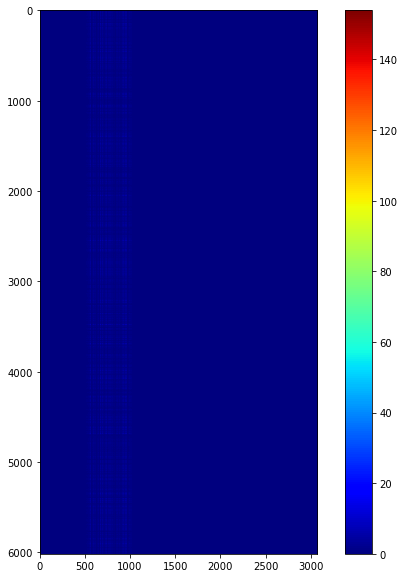

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

In [24]:
pd.DataFrame(ext_data['train']['features'])

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.147946,0.175732,0.142505,0.090203,0.108537,0.147906,0.308280,0.265295,0.245101,0.256480,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000072,0.000000
1,0.116080,0.116188,0.159417,0.098484,0.095091,0.219743,0.297274,0.184091,0.263881,0.238064,...,0.001663,0.000000,0.000000,0.0,0.001744,0.0,0.000000,0.0,0.000000,0.000417
2,0.112816,0.113836,0.189923,0.080989,0.092794,0.196423,0.302949,0.185624,0.282092,0.243462,...,0.000376,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000471
3,0.127746,0.136979,0.201429,0.084496,0.096617,0.145473,0.287810,0.190862,0.267372,0.233798,...,0.000785,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.152278,0.133729,0.169552,0.058810,0.129370,0.227634,0.282119,0.187905,0.262822,0.302787,...,0.010431,0.000266,0.000034,0.0,0.000607,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,0.141273,0.160406,0.200182,0.061591,0.108358,0.151978,0.294190,0.204515,0.289770,0.276365,...,0.000000,0.000139,0.001166,0.0,0.010003,0.0,0.000000,0.0,0.000000,0.002949
6014,0.122717,0.099516,0.159321,0.116796,0.101590,0.223139,0.258506,0.150838,0.240842,0.234708,...,0.001269,0.000000,0.001307,0.0,0.009879,0.0,0.000152,0.0,0.000000,0.005065
6015,0.113642,0.128419,0.203545,0.062633,0.095845,0.156228,0.300381,0.182563,0.299790,0.251192,...,0.000000,0.003193,0.000390,0.0,0.000057,0.0,0.000000,0.0,0.004477,0.000000
6016,0.124148,0.120036,0.163488,0.088960,0.096707,0.215398,0.293453,0.193919,0.261305,0.239540,...,0.000197,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000245


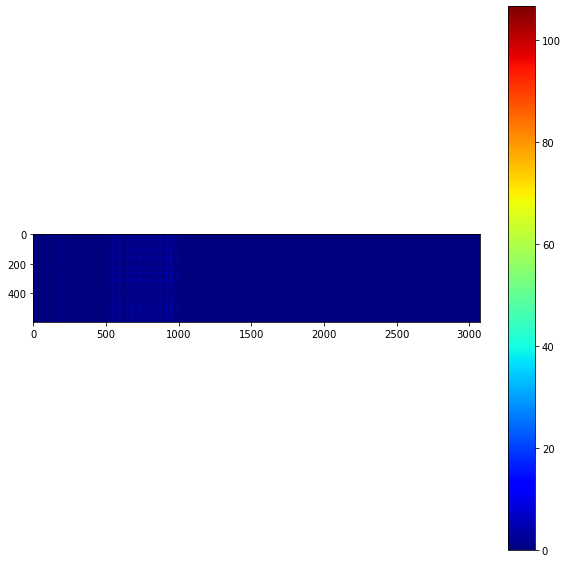

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_source']['features'], cmap='jet')
plt.colorbar()

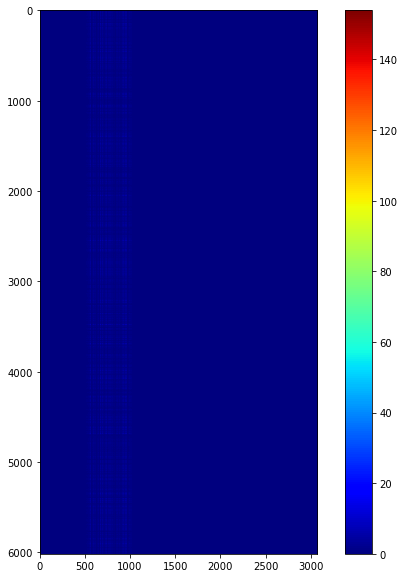

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)

#### print(M_means.shape)
plt.imshow(M_means, aspect='auto', cmap='jet')
plt.title(phase)
plt.colorbar()
plt.show()